Epoch 1/5
391/391 [==============================] - 379s 968ms/step - loss: 3.8297 - accuracy: 0.1664 - val_loss: 4.2665 - val_accuracy: 0.0854
Epoch 2/5
391/391 [==============================] - 394s 1s/step - loss: 2.7435 - accuracy: 0.3300 - val_loss: 2.4702 - val_accuracy: 0.3808
Epoch 3/5
391/391 [==============================] - 378s 967ms/step - loss: 2.0648 - accuracy: 0.4610 - val_loss: 2.3326 - val_accuracy: 0.4114
Epoch 4/5
391/391 [==============================] - 384s 982ms/step - loss: 1.4838 - accuracy: 0.5978 - val_loss: 2.3409 - val_accuracy: 0.4288
Epoch 5/5
391/391 [==============================] - 375s 957ms/step - loss: 0.9072 - accuracy: 0.7483 - val_loss: 2.4391 - val_accuracy: 0.4178


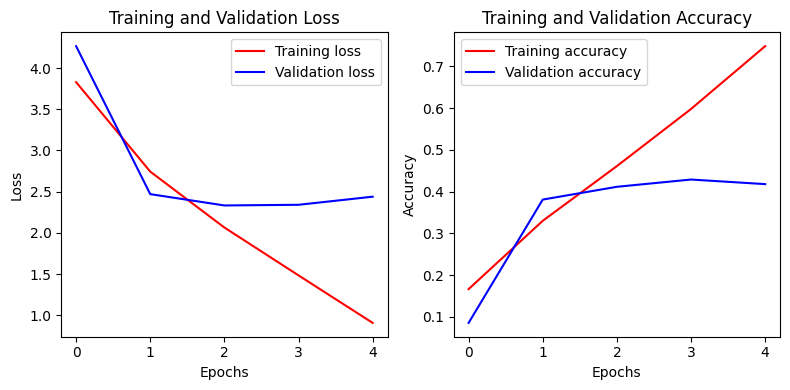

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Load the CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

# Preprocess the data
num_classes = 100

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Define the model architecture
model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=x_train.shape[1:]),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the early stopping callback
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(x_train, y_train, batch_size=128, epochs=5,
                    validation_data=(x_test, y_test), callbacks=[early_stopping])

# Plot the training and validation loss and accuracy
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(loss))

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16

# load VGG16 model without classifier layers
vgg = VGG16(input_shape=(224, 224, 3), include_top=False)

# mark loaded layers as not trainable
for layer in vgg.layers:
    layer.trainable = False

# add new classifier layers
flat1 = Flatten()(vgg.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(5, activation='softmax')(class1)

# define the new model
model = Model(inputs=vgg.inputs, outputs=output)

# compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# print summary of the model
model.summary()

# create dummy data
import numpy as np
import os
from PIL import Image

train_dir = 'train_data'
os.makedirs(train_dir, exist_ok=True)

test_dir = 'test_data'
os.makedirs(test_dir, exist_ok=True)

# create 1000 training images and 200 test images for each class
classes = ['class_0', 'class_1', 'class_2', 'class_3', 'class_4']
for c in classes:
    os.makedirs(os.path.join(train_dir, c), exist_ok=True)
    os.makedirs(os.path.join(test_dir, c), exist_ok=True)
    for i in range(1000):
        img = Image.fromarray(np.random.randint(0, 256, (224, 224, 3), dtype=np.uint8))
        img.save(os.path.join(train_dir, c, '{}.png'.format(i)))
    for i in range(200):
        img = Image.fromarray(np.random.randint(0, 256, (224, 224, 3), dtype=np.uint8))
        img.save(os.path.join(test_dir, c, '{}.png'.format(i)))

# create data generators
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   horizontal_flip=True, 
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(224, 224),
                                                    batch_size=32, 
                                                    class_mode='categorical', 
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(train_dir, 
                                                         target_size=(224, 224),
                                                         batch_size=32, 
                                                         class_mode='categorical', 
                                                         subset='validation')

# train the model
history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    validation_data=validation_generator, 
                    validation_steps=len(validation_generator), 
                    epochs=20)

# evaluate the model on test data
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(224, 224), 
                                                  batch_size=32, 
                                                  class_mode='categorical')
loss, accuracy = model.evaluate(test_generator, steps=len(test_generator))
print('Test accuracy: {}'.format(accuracy))


KeyboardInterrupt



In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar100

# Load the CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# Normalize the pixel values to be between 0 and 1
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Convert the labels to one-hot encoding
y_train = keras.utils.to_categorical(y_train, num_classes=100)
y_test = keras.utils.to_categorical(y_test, num_classes=100)

# Define the model architecture
model = keras.Sequential(
    [
        # Convolutional layers
        layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Dense layers
        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(100, activation="softmax"),
    ]
)

# Define the optimizer, loss function, and metric
optimizer = keras.optimizers.RMSprop(learning_rate=1e-4)
loss_fn = keras.losses.CategoricalCrossentropy()
metric = keras.metrics.CategoricalAccuracy()

# Compile the model
model.compile(optimizer=optimizer, loss=loss_fn, metrics=[metric])

# Define the early stopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

# Train the model
history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=5,
    validation_split=0.1,
    callbacks=[early_stopping_cb],
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

Epoch 1/5
1407/1407 [==============================] - 115s 81ms/step - loss: 4.6080 - categorical_accuracy: 0.0814 - val_loss: 3.4299 - val_categorical_accuracy: 0.2042
Epoch 2/5
1407/1407 [==============================] - 113s 80ms/step - loss: 3.7851 - categorical_accuracy: 0.1572 - val_loss: 3.1665 - val_categorical_accuracy: 0.2562
Epoch 3/5
1407/1407 [==============================] - 115s 81ms/step - loss: 3.4064 - categorical_accuracy: 0.2132 - val_loss: 2.9408 - val_categorical_accuracy: 0.2982
Epoch 4/5
1407/1407 [==============================] - 115s 82ms/step - loss: 3.1361 - categorical_accuracy: 0.2603 - val_loss: 2.8944 - val_categorical_accuracy: 0.3174
Epoch 5/5
313/313 [==============================] - 4s 12ms/step - loss: 2.6311 - categorical_accuracy: 0.3617
Test loss: 2.6311
Test accuracy: 0.3617


KeyError: 'accuracy'

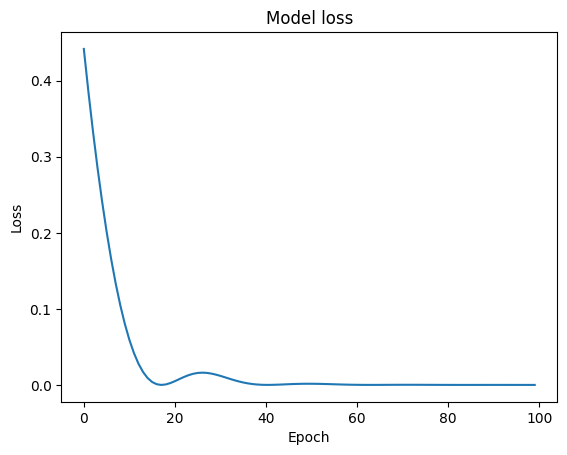

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
import numpy as np
import matplotlib.pyplot as plt

# Define the input sequence and output sequence
input_sequence = np.array([[0.1, 0.2, 0.3], [0.2, 0.3, 0.4], [0.3, 0.4, 0.5], [0.4, 0.5, 0.6]])
output_sequence = np.array([0.4, 0.5, 0.6, 0.7])

# Define the RNN model
model = Sequential()
model.add(SimpleRNN(32, input_shape=(3, 1)))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(input_sequence.reshape(4, 3, 1), output_sequence, epochs=100, verbose=0)

# Plot the training loss
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16

# load VGG16 model without classifier layers
vgg = VGG16(input_shape=(224, 224, 3), include_top=False)

# mark loaded layers as not trainable
for layer in vgg.layers:
    layer.trainable = False

# add new classifier layers
flat1 = Flatten()(vgg.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(5, activation='softmax')(class1)

# define the new model
model = Model(inputs=vgg.inputs, outputs=output)

# compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# print summary of the model
model.summary()

# create dummy data
import numpy as np
import os
from PIL import Image

train_dir = 'train_data'
os.makedirs(train_dir, exist_ok=True)

test_dir = 'test_data'
os.makedirs(test_dir, exist_ok=True)

# create 100 training images and 20 test images for each class
classes = ['class_0', 'class_1', 'class_2', 'class_3', 'class_4']
for c in classes:
    os.makedirs(os.path.join(train_dir, c), exist_ok=True)
    os.makedirs(os.path.join(test_dir, c), exist_ok=True)
    for i in range(50):
        img = Image.fromarray(np.random.randint(0, 256, (224, 224, 3), dtype=np.uint8))
        img.save(os.path.join(train_dir, c, '{}.png'.format(i)))
    for i in range(10):
        img = Image.fromarray(np.random.randint(0, 256, (224, 224, 3), dtype=np.uint8))
        img.save(os.path.join(test_dir, c, '{}.png'.format(i)))

# create data generators
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   horizontal_flip=True, 
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(224, 224),
                                                    batch_size=32, 
                                                    class_mode='categorical', 
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(train_dir, 
                                                         target_size=(224, 224),
                                                         batch_size=32, 
                                                         class_mode='categorical', 
                                                         subset='validation')

# train the model
history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    validation_data=validation_generator, 
                    validation_steps=len(validation_generator), 
                    epochs=5)

# evaluate the model on test data
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(224, 224), 
                                                  batch_size=32, 
                                                  class_mode='categorical')
loss, accuracy = model.evaluate(test_generator, steps=len(test_generator))
print('Test accuracy: {}'.format(accuracy))

import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

ImportError: Image transformations require SciPy. Install SciPy.